In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
test_spread = pd.read_csv("test_spread.csv", index_col=0) # 2021/08/06+
test_z_score = pd.read_csv("test_z_score.csv", index_col=0) # 2021/08/23+
z_score_optim = pd.read_csv("z_score_optim.csv", index_col=0)
test_spread = test_spread.iloc[11:,:] # Resccale to 2021/08/23+
# test_spread

In [38]:
def testing_backtest(params, spread, z_score, pair_name):
    entryZscore, exitZscore = params
    PnL = pd.DataFrame({f"{pair_name}": z_score})
    PnL.index = pd.to_datetime(z_score.index)
    PnL['long entry'] = [x < (-entryZscore) and z_score[-1] > (-entryZscore) for x in z_score]
    PnL['long exit'] = [x > (-exitZscore) and z_score[-1] < (-exitZscore) for x in z_score]
    PnL['num units long'] = np.zeros(len(PnL))
    PnL.loc[PnL['long entry'],'num units long'] = 1 
    PnL.loc[PnL['long exit'],'num units long'] = 0 
        
    PnL['short entry'] = [x > (-entryZscore) and z_score[-1] < (-entryZscore) for x in z_score]
    PnL['short exit'] = [x < (-exitZscore) and z_score[-1] > (-exitZscore) for x in z_score]
    PnL['num units short'] = np.zeros(len(PnL))
    PnL.loc[PnL['short entry'],'num units short'] = -1
    PnL.loc[PnL['short exit'],'num units short'] = 0
    
    PnL['numUnits'] = PnL['num units long'] + PnL['num units short']
    PnL['spread pct ch'] = (spread - spread.shift(1)).values
    PnL['port rets'] = PnL['spread pct ch'] * PnL['numUnits'].shift(1)
    PnL['cum rets'] = PnL['port rets'].cumsum()
    PnL['cum rets'] = PnL['cum rets'] + 1
    end_val = PnL['cum rets'].iat[-1]
    days = (PnL.index[-1] - PnL.index[0]).days
    annual_return = (end_val) ** (252.0/days) - 1

    try:
        sharpe_ratio = ((PnL['port rets'].mean() / PnL['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe_ratio = 0.0
    return(PnL, end_val, sharpe_ratio, annual_return)

In [40]:
PnL_list= []
Profit = pd.DataFrame()
Profit.index = test_z_score.columns
Profit["Profit"] = np.zeros(len(test_z_score.columns))
Profit["Sharpe Ratio"] = np.zeros(len(test_z_score.columns))
Profit["Annual Return"] = np.zeros(len(test_z_score.columns))
for pair in range(test_z_score.shape[1]):
    pair_name = test_z_score.columns[pair]
    spread = test_spread.iloc[:,pair]
    z_score = test_z_score[pair_name]
    params = [z_score_optim.iloc[pair,1], z_score_optim.iloc[pair,2]]
    result = testing_backtest(params, spread, z_score, pair_name)
    PnL_list.append(result[0])
    Profit.iloc[pair,:] = result[1:4]
Profit

C:\Users\user\AppData\Local\Temp\ipykernel_2820\471328612.py:24: RuntimeWarning: invalid value encountered in scalar power
  annual_return = (end_val) ** (252.0/days) - 1


,Profit,Sharpe Ratio,Annual Return
ORCL GOOGL,94.779680,1.595363,2.806920
USLV GLD,367.119573,2.011350,4.666307
USLV AAPL,320.865417,1.673583,4.446567
USLV GOOGL,331.884522,1.890726,4.500849
USLV AMD,128.633623,0.986651,3.164191
...,...,...,...
CMCSA VDC,115.411382,1.522960,3.033624
CMCSA KXI,36.438896,1.422598,1.875024
CMCSA VHT,194.544558,2.127579,3.702181
CMCSA VNQ,60.428163,1.665880,2.335502


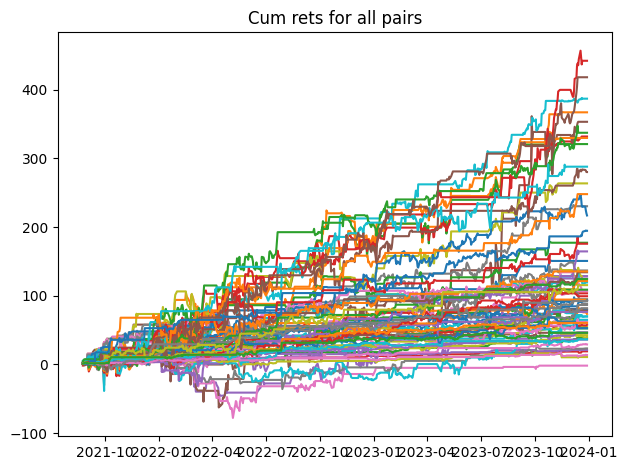

In [55]:
for pair in range(len(PnL_list)):
    plt.plot(PnL_list[pair]["cum rets"].dropna())
plt.title("Cum rets for all pairs")
plt.tight_layout()
plt.show()

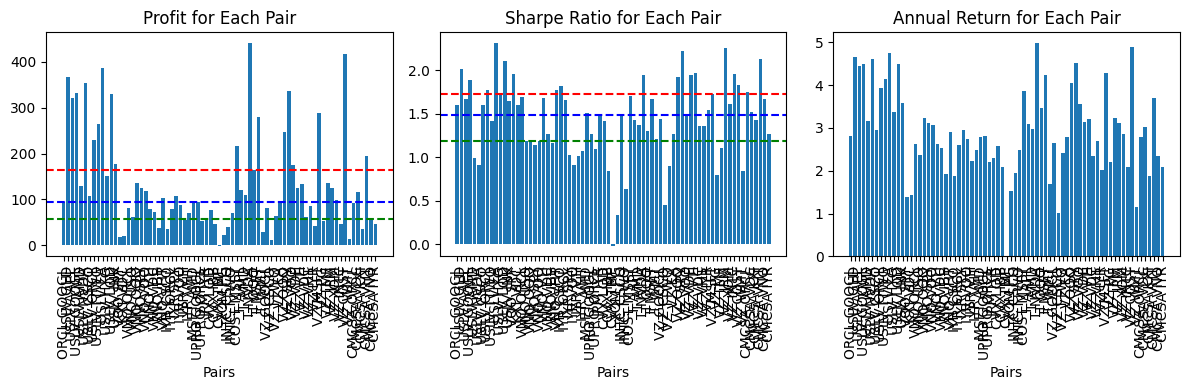

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for col in range(Profit.shape[1]):
    data = Profit.iloc[:,col]
    quartiles = np.percentile(data, [25, 50, 75])
    axs[col].bar(Profit.index, data)
    axs[col].set_xlabel("Pairs")
    axs[col].set_title(f"{Profit.columns[col]} for Each Pair")
    axs[col].tick_params(axis='x', rotation=90)
    axs[col].axhline(quartiles[0], color='green', linestyle='--', label='Lower Quartile')
    axs[col].axhline(quartiles[1], color='blue', linestyle='--', label='Median')
    axs[col].axhline(quartiles[2], color='red', linestyle='--', label='Upper Quartile')
plt.tight_layout()
plt.show()

In [56]:
PnL_ts = pd.DataFrame()
PnL_ts.index =  PnL_list[0].index
for pair in range(len(PnL_list)):
    data = PnL_list[pair]
    pair_name = data.columns[0]
    PnL_ts[pair_name] = data["cum rets"]

In [57]:
ew_PnL = PnL_ts.dropna()
ew_PnL /= len(ew_PnL.columns)
ew_PnL.sum(axis=1)

Index
2021-08-24      1.180832
2021-08-25      1.396957
2021-08-26      1.745326
2021-08-27      1.885142
2021-08-30      2.189333
                 ...    
2023-12-22    132.102337
2023-12-26    132.116560
2023-12-27    132.076883
2023-12-28    131.996913
2023-12-29    131.935803
Length: 592, dtype: float64